In [261]:
import numpy as np
import matplotlib.pyplot as plt 

def load_dataset(path):
    """Load the data in file to ndarrays of x matrix and array of y labels.
    
    Args:
        path: path to the text file containing data.
    Returns:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of labels. Shape (m,)
    """
    with open(path, 'r') as fr:
        first_row = fr.readline().strip().split('\t')
    x_cols = [i for i in range(len(first_row) - 1)]
    l_col = [len(first_row) - 1]

    dataset = np.loadtxt(path, dtype=float, delimiter='\t', usecols=x_cols)
    labels = np.loadtxt(path, dtype=float, delimiter='\t', usecols=l_col)
    return dataset, labels

def select_random_j(i, m):
    """Select a random j in m numbers with j not equal to m.
    
    Args:
        i: index of alpha i
        m: number of examples
    Returns:
        j: integer that's not i    
    """
    j = i
    while (j == i):
        j = int(np.random.uniform(0, m))
    return j

def clip_alpha(alpha_j, L, H):
    """Clip alpha to make it lie in the [L, H] interval.
    
    Args:
        alpha_j: jth alpha to be clipped
        L: the low boundary of the interval
        H: the high boundary of the interval
    Returns:
        alpha_j: the clipped alpha_j
    """
    if alpha_j > H:
        alpha_j = H
    elif alpha_j < L:
        alpha_j = L
    else:
        alpha_j = alpha_j
    return alpha_j

def smo_simplified(dataset, labels, C, tolerance, max_iter):
    """Use simplified SMO algorithm to solve for SVM.
    
    Args:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of labels. Shape (m,)
        C: the violation parameter
        tolerance: 
        max_iter: maximum iteration allowed for SMO
    Returns:
        alpha: array of alpha parameters
        b: intercept parameter. Integer
    """
    m, n = dataset.shape
    alpha = np.zeros(m)
    b = 0
    iteration = 0

    while (iteration < max_iter):
        alpha_pair_changed = 0  # flag for a pair of alphas changed

        for i in range(m):
            f_i = (alpha * labels).dot(dataset.dot(dataset[i])) + b
            err_i = f_i - labels[i]

            # check if it fulfills the KKT conditions
            if (labels[i] * err_i < -tolerance and alpha[i] < C) or (labels[i] * err_i > tolerance and alpha[i] > 0):
                j = select_random_j(i, m)
                f_j = (alpha * labels).dot(dataset.dot(dataset[j])) + b
                err_j = f_j - labels[j]

                alpha_i_pre = np.copy(alpha[i])
                alpha_j_pre = np.copy(alpha[j])

                # choose the low and high boundary for alpha i & j
                if labels[i] == labels[j]:
                    L = max(0, alpha[j] + alpha[i] - C)
                    H = min(C, alpha[j] + alpha[i])
                else:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                
                # calculate eta and update alpha j
                eta = 2.0 * dataset[i].dot(dataset[j]) - dataset[i].dot(dataset[i]) - dataset[j].dot(dataset[j])
                if eta >= 0:
                    print('eta >= 0')
                    continue
                
                alpha[j] -= labels[j] * (err_i - err_j) / eta
                alpha[j] = clip_alpha(alpha[j], L, H)
                if abs(alpha[j] - alpha_j_pre < 1e-5):
                    print("alpha j not moving enough")
                    continue

                # update alpha i
                alpha[i] += labels[i] * labels[j] * (alpha_j_pre - alpha[j])    # update alpha i by the same amount as j

                # update b
                b1 = b - err_i - labels[i] * (alpha[i] - alpha_i_pre) * dataset[i].dot(dataset[i]) \
                               - labels[j] * (alpha[j] - alpha_j_pre) * dataset[j].dot(dataset[i])
                b2 = b - err_j - labels[i] * (alpha[i] - alpha_i_pre) * dataset[i].dot(dataset[j]) \
                               - labels[j] * (alpha[j] - alpha_j_pre) * dataset[j].dot(dataset[j])
                if 0 < alpha[i] and alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] and alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                # change flag
                alpha_pair_changed += 1
                print("Iteration: {0} i: {1}, pairs changed: {2}".format(iteration, i, alpha_pair_changed))

        if alpha_pair_changed == 0:  # if alpha pairs stays unchanged for max_iter, 
            iteration += 1           # then alphas are solved and can quit loop
        else:
            iteration = 0
        print('itration number: {}'.format(iteration))
    
    return alpha, b

####################################################################################

class ModelStructure(object):
# """Data Structure for storing parameters."""
    def __init__(self, dataset, labels, C, tolerance):
        """
        Args:
            dataset: ndarray of x matrix. Shape (m, n)
            labels: array of y labels. Shape (m,)
            C: slack parameter
            tolerance: error tolerance. floating point
        """
        self.dataset = dataset
        self.labels = labels
        self.C = C
        self.tolerance = tolerance
        self.m = dataset.shape[0]
        self.n = dataset.shape[1]
        self.alpha = np.zeros(self.m)
        self.b = 0
        self.err = np.zeros((self.m, 2))    # first column is a valid flag

def calculate_error(ds, k):
    """Calculate the error given alpha[k]
        
    Args:
        ds: the data structure of model
        k: kth alpha
    """
    err_k = (ds.alpha * ds.labels).dot(ds.dataset.dot(ds.dataset[k])) + ds.b - ds.labels[k]
    return err_k

def select_j(ds, i, err_i):
    """Given alpha[i], select alpha[j] that gives the maximum delta err
    
    Args:
        ds: the data structure of model
        i: the ith alpha in array
        err_i: the error calculated for alpha[i]
    Returns:
        best_j: j that renders the max delta error
        best_j_err: the error of the selected alpha j
    """
    # initialize j
    best_j = -1
    best_j_err = 0
    max_delta_err = 0
    ds.err[i] = [1, err_i]  # set valid 

    # take the index of alphas that has valid error cache
    valid_err_ind = [ind for ind in range(ds.m) if ds.err[ind, 0] > 0] 

    # loop through alpha that gives max delta err
    if len(valid_err_ind) > 1:
        for j in valid_err_ind:
            if j == i: continue
            err_j = calculate_error(ds, j)
            delta_err = abs(err_i - err_j)

            if delta_err > max_delta_err:
                best_j = j
                max_delta_err = delta_err
                best_j_err = err_j
        return best_j, best_j_err
    else:   # no valid error cache values (first round)
        best_j = select_random_j(i, ds.m)
        best_j_err = calculate_error(ds, best_j)
    return best_j, best_j_err

def smo_full(dataset, labels, C, tolerance, max_iter):
    """Full Platt SMO
    
    Args:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of y labels. Shape (m,)
        C: slack parameter
        tolerance: error tolerance. floating point
        max_iter: maximum iterations
    Returns:
        ds.alpha: the alpha parameter of model
        ds.b: the b paramter of model data structure
    """
    ds = ModelStructure(dataset, labels, C, tolerance)
    iter = 0
    full_scan = True
    alpha_pair_changed = 0

    # Select alpha i: from support vector or from whole dataset
    # first, scan the whole dataset to change alpha
    # after first round, optimize the alpha within interval[0, C], these are support vectors.
    # if for sup_vec, no alpha pairs changed, scan full data again to update alpha pairs.
    # stop until: 1. no alpha pairs need to update, then keep scanning full data until reach max_cycle
    #             2. just update alpha pairs until reach maximum cycle
    while iter < max_iter and (alpha_pair_changed > 0 or full_scan):
        alpha_pair_changed = 0

        if full_scan:
            for i in range(ds.m):
                alpha_pair_changed += inner_loop(i, ds)
                print("fullset iteration: {} i: {}, pairs changed: {}".format(iter, i, alpha_pair_changed))
        else:
            # select from support vectors, i.e. 0 < alpha i < C
            non_bound_ind = [ind for ind in range(ds.m) if (ds.alpha[ind] > 0 and ds.alpha[ind] < ds.C)]

            for i in non_bound_ind:
                alpha_pair_changed += inner_loop(i, ds)
                print("non-bound iteration: {} i: {}, pairs changed: {}".format(iter, i, alpha_pair_changed))
            iter += 1

        if full_scan: 
            full_scan = False
        elif alpha_pair_changed == 0:
            full_scan = True
        print("iteration number: {}".format(iter))
    
    return ds.alpha, ds.b

def inner_loop(i, ds):
    """Inner loop to find and update alpha j.
    
    Args:
        i: index of the first alpha in pair
        ds: the data structure of SVM model
    Returns:
        0 if no alpha pairs changed. 1 if a pair of alpha changed.
    """
    err_i = calculate_error(ds, i)

    if (ds.labels[i] * err_i < -ds.tolerance and ds.alpha[i] < ds.C) or \
        (ds.labels[i] * err_i > ds.tolerance and ds.alpha[i] > 0):
        j, err_j = select_j(ds, i, err_i)

        alpha_i_pre = np.copy(ds.alpha[i])
        alpha_j_pre = np.copy(ds.alpha[j])

        if ds.labels[i] == ds.labels[j]:
            L = max(0, ds.alpha[j] + ds.alpha[i] - ds.C)
            H = min(ds.C, ds.alpha[j] + ds.alpha[i])
        else:
            L = max(0, ds.alpha[j] - ds.alpha[i])
            H = min(ds.C, ds.C + ds.alpha[j] - ds.alpha[i])
        if L == H: print("L==H"); return 0
        
        eta = 2.0 * ds.dataset[i].dot(ds.dataset[j]) - ds.dataset[i].dot(ds.dataset[i]) - ds.dataset[j].dot(ds.dataset[j])
        if eta >= 0: print("eta >= 0"); return 0

        ds.alpha[j] -= ds.labels[j] * (err_i - err_j) / eta
        ds.alpha[j] = clip_alpha(ds.alpha[j], L, H)
        ds.err[j] = [1, err_j]

        if abs(ds.alpha[j] - alpha_j_pre) < 1e-5:
            print("alpha j is not moving enough")
            return 0

        ds.alpha[i] += ds.labels[i] * ds.labels[j] * (alpha_j_pre - ds.alpha[j])
        ds.err[i] = [1, err_i]

        b1 = ds.b - err_i - ds.labels[i] * (ds.alpha[i] - alpha_i_pre) * ds.dataset[i].dot(ds.dataset[i]) \
                          - ds.labels[j] * (ds.alpha[j] - alpha_j_pre) * ds.dataset[j].dot(ds.dataset[i])
        b2 = ds.b - err_j - ds.labels[i] * (ds.alpha[i] - alpha_i_pre) * ds.dataset[i].dot(ds.dataset[j]) \
                          - ds.labels[j] * (ds.alpha[j] - alpha_j_pre) * ds.dataset[j].dot(ds.dataset[j])
        
        if 0 < ds.alpha[i] and ds.alpha[i] < ds.C:
            ds.b = b1
        elif 0 < alpha[j] and alpha[j] < ds.C:
            ds.b = b2
        else:
            ds.b = (b1 + b2) / 2
        
        return 1
    else:
        return 0
    
def plot_model(dataset, labels, alpha, b, save_path):
    """Plot the SVM classifier and support vectors
    
    Args:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of labels. Shape (m,)
        alpha: array of alpha parameters
        b: intercept parameter. Integer
    """
    w = dataset.T.dot(alpha*labels)
    sup_vec = dataset[alpha > 0, :]

    fig, ax = plt.subplots()
    ax.plot(dataset[labels==1, 0], dataset[labels==1, 1], "bx", linewidth=2)
    ax.plot(dataset[labels==-1, 0], dataset[labels==-1, 1], 'go', linewidth=2)
    x1 = np.arange(min(dataset[:, 0])*0.8, max(dataset[:, 0])*1.2, 0.01)  # 20% margin
    x2 = -(b + w[0] * x1) / w[1]
    ax.plot(x1, x2, c = 'red', linewidth=2)
    ax.set_ylim(-7, 7)

    for i in range(sup_vec.shape[0]):
        ax.scatter(sup_vec[i, 0], sup_vec[i, 1], color='', marker='o', edgecolors='orange', s=200)
    
    plt.savefig(save_path)
    plt.show()
    

#############################################################################

In [232]:
dataset, labels = load_dataset('testSet.txt')

In [233]:
alpha, b = smo_simplified(dataset, labels, 0.6, 0.001, 100)

alpha j not moving enough
Iteration: 0 i: 1, pairs changed: 1
Iteration: 0 i: 4, pairs changed: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 18, pairs changed: 3
Iteration: 0 i: 23, pairs changed: 4
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 35, pairs changed: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 54, pairs changed: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 69, pairs changed: 7
itration number: 0
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 18, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 2 i: 34, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j 

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j

alpha j not moving enough
alpha j not moving enough
itration number: 12
alpha j not moving enough
alpha j not moving enough
itration number: 13
alpha j not moving enough
alpha j not moving enough
itration number: 14
alpha j not moving enough
alpha j not moving enough
itration number: 15
alpha j not moving enough
alpha j not moving enough
itration number: 16
alpha j not moving enough
alpha j not moving enough
itration number: 17
alpha j not moving enough
alpha j not moving enough
itration number: 18
alpha j not moving enough
alpha j not moving enough
itration number: 19
alpha j not moving enough
alpha j not moving enough
itration number: 20
alpha j not moving enough
alpha j not moving enough
itration number: 21
alpha j not moving enough
alpha j not moving enough
itration number: 22
alpha j not moving enough
alpha j not moving enough
itration number: 23
alpha j not moving enough
alpha j not moving enough
itration number: 24
alpha j not moving enough
alpha j not moving enough
itration num

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
Iteration: 7 i: 29, pairs changed: 1
alpha j not moving enough
alpha j no

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 55
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 56
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 57
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 58
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j no

In [234]:
alpha[alpha > 0]

array([0.14551432, 0.05716861])

C:\Users\ziman\anaconda3\lib\site-packages\ipykernel_launcher.py:329: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


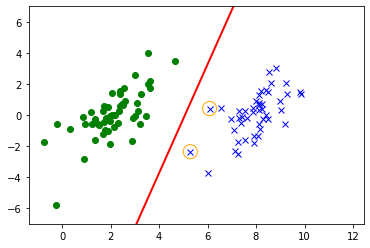

In [262]:
plot_model(dataset, labels, alpha, b)

In [246]:
alpha2, b2 = smo_full(dataset, labels, 0.6, 0.001, 100)

L==H
fullset iteration: 0 i: 0, pairs changed: 0
L==H
fullset iteration: 0 i: 1, pairs changed: 0
fullset iteration: 0 i: 2, pairs changed: 1
L==H
fullset iteration: 0 i: 3, pairs changed: 1
fullset iteration: 0 i: 4, pairs changed: 2
fullset iteration: 0 i: 5, pairs changed: 2
fullset iteration: 0 i: 6, pairs changed: 2
alpha j is not moving enough
fullset iteration: 0 i: 7, pairs changed: 2
L==H
fullset iteration: 0 i: 8, pairs changed: 2
fullset iteration: 0 i: 9, pairs changed: 2
L==H
fullset iteration: 0 i: 10, pairs changed: 2
L==H
fullset iteration: 0 i: 11, pairs changed: 2
L==H
fullset iteration: 0 i: 12, pairs changed: 2
fullset iteration: 0 i: 13, pairs changed: 2
L==H
fullset iteration: 0 i: 14, pairs changed: 2
fullset iteration: 0 i: 15, pairs changed: 2
fullset iteration: 0 i: 16, pairs changed: 2
L==H
fullset iteration: 0 i: 17, pairs changed: 2
fullset iteration: 0 i: 18, pairs changed: 3
fullset iteration: 0 i: 19, pairs changed: 3
fullset iteration: 0 i: 20, pairs ch

C:\Users\ziman\anaconda3\lib\site-packages\ipykernel_launcher.py:329: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


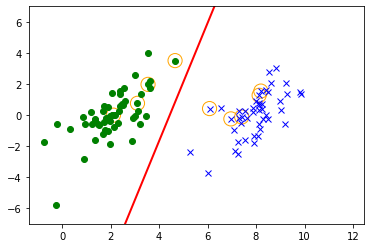

In [263]:
plot_model(dataset, labels, alpha2, b2)